In [1]:
from IPython.core.display import HTML
#css_file = '/Users/Luis/numerical-mooc/styles/numericalmoocstyle.css'
css_file = './numericalmoocstyle.css'
HTML(open(css_file, "r").read())

In [2]:
import numpy
from numpy import pi
#
import sympy
import math
#
import scipy
from scipy import constants
#
import matplotlib.pyplot 
#
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, cm
%matplotlib inline
#
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
#
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

### Domain

In [3]:
def get_domain(Ld, n_gap):
    ''' This function obtains the domain based on a 
    staggered grid. The domain is divided into three parts:
    (1) anode region, (2) gap, (3) cathode.
    
    Parameters:
    ----------
    Ld: Domain Length
    n_gap: number of boundary nodes in gap
    
    Returns:
    --------
    '''
    #staggered grid approach
    #gap region
    xl_gap = 0.0
    xr_gap = Ld
    delx_gap = (xr_gap-xl_gap)/(n_gap-1.0)
    xb_gap = numpy.linspace(xl_gap, xr_gap, n_gap)
    xc_gap = xb_gap[:-1]+(delx_gap*0.5)
    #
    #
    return delx_gap, xb_gap, xc_gap
    

In [4]:
# Domain, Dimensions
L_chamber = 0.24  #meters
Lgap = 0.004 #interelectrode gap [meters]
L_cathode = 0.112
L_anode = L_chamber - (Lgap + L_cathode)
#
nx_anode = 101
nx_cathode = 111
nx_gap = 121
#
Rc = (12.5/2.) * 1./1000. # cathode radius [meters]
Ran = 6.35/2. * 1./1000.  #anode radius [meters]

#get cell boundary and cell center locations
dx_g, xb, xc = get_domain(Lgap,nx_gap)
#
l2_target = 1e-7

In [5]:
numpy.shape(xb)

(121,)

In [6]:
numpy.shape(xc)

(120,)

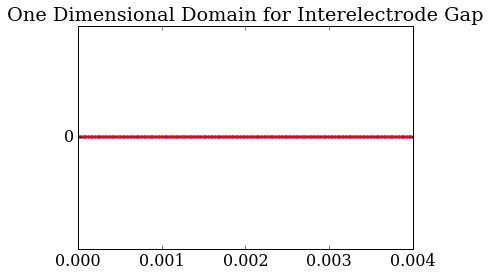

In [7]:
Xc_gap = numpy.meshgrid(xc)
Xb_gap = numpy.meshgrid(xb)
#
pyplot.title('One Dimensional Domain for Interelectrode Gap')
pyplot.ylim(-.0002,0.0002)
pyplot.xlim(0., Lgap)
pyplot.scatter(Xb_gap,numpy.zeros_like(Xb_gap),\
                   s=10, color='b', marker='o', linewidth=0)
pyplot.scatter(Xc_gap,numpy.zeros_like(Xc_gap), \
                   s=10, color='r', marker='o', linewidth=0)
pyplot.xticks(numpy.arange(0, Lgap+0.001, 0.001))
pyplot.yticks(numpy.arange(0, 0.0002, 0.001));

Note that velocities are calculated on the cell boundaries (blue), and the pressure, density,electrical conductivity, potential, current density and temperature are calculated on the cell center (red)

### Initialization

In [8]:
def L2_error(p_new, p_old):
    '''This function computes the L2 norm of the error for convergence
    
    This function is used for convergence of the pressure equation

    Parameters:
    ----------
    p_new: new computed potential in flow field
    p_old: previous flow field potential
    
    Returns:
    ----------
    error!
    
    1:-1,1:-1
    '''
    
    return numpy.sqrt(numpy.sum((p_new[:] - p_old[:])**2)\
                      /numpy.sum(p_old[:]**2))

In [9]:
#Input Current
I_arc = 60.0

#Initialization Variables
gamma1 = 5.0/3.0
gravity = 9.81

# collision radius Carbon-Helium:
cr_C_He = (1.7 + 1.4)

#Constants
Ckb = scipy.constants.k  #Boltzmann Constant J/K
Cme = scipy.constants.m_e #Elementary Electron Mass kg
Ch = scipy.constants.h; # Planck's constant Js
CA = 1.2e6 #constant in electron current density eqn [A/(m^2 K^2)], pg.62

CNA = scipy.constants.N_A #avogadros number

Ce = scipy.constants.e #elementary charge, C

#Carbon
M_carbon = 12.0e-3/CNA #kg, mass of 1 atom of pure carbon
mC = 12.0107 # molar mass g/mol
Ips1 = 1086.5e3/CNA #J, energy of first ionization
anode_workfunction = 4.81 #eV
emissivity=0.70 #carbon, graphite
E_C = 11.2603*constants.e #ionization energy for carbon in Joules
R_C = 8314.0/mC #specific gas constant

#heat of vaporization anode:
dH_C = 710.0e6/mC
#
#Helium
M_helium = 4.0e-3/CNA # kg, mass of 1 atom of Helium
mHe = 4.002602 #molar mass, g/mol
Ipg1 = 2372.3e3/CNA; # J, energy of first ionization

R_He = 8314.0/mHe #specific gas constant
#       
dt = 0.000015 # {sec} time step

##### Initial Conditions

In [10]:
def get_initial_conditions(x1,x2,I_input,R_anode, phi_cathode):
    '''
    Defines initial variables 
    add two ghost cells to represent nodes on anode and cathode
    
    Parameters:
    -----------
    x1: boundary x locations
    x2: center cell x locations
    I_input: arc current input
    R_anode: anode radius
    
    Returns:
    -------
    jx:current density
    phi_x: electric potential
    cp_x: specific heat
    Tx: Temperature
    e_cond: electrical conductivity
    visc: viscosity
    k_cond: thermal conductivty
    ne_x: number density of electrons
    
    Assume vent conditions and that only anode is modeled
    '''
    Tref = 300.0
    #
    a = numpy.size(x1) + 2 #this is to add ghost cells, these are boundary cells
    b = numpy.size(x2) + 2 #this is to add ghost cells, these are center cells
    #------------------------------------------
    #grid 1 (cell edges)
    ux = numpy.zeros((a),dtype=float) #velocity
    #grid 2 cell centers-----------------------
    jx = numpy.zeros((b), dtype=float) #current density
    phi_x = numpy.zeros((b),dtype=float) #electric potential
    e_cond = numpy.zeros((b),dtype=float) #electrical conductivity
    rho_x = numpy.zeros((b),dtype=float) #density
    ne_x = numpy.zeros((b), dtype=float) #number density of electrons
    #
    cp_x = numpy.zeros((b),dtype=float) #specific heat
    Tx = numpy.zeros((b),dtype=float) #temperature
    visc = numpy.zeros((b),dtype=float) #viscosity
    k_cond = numpy.zeros((b),dtype=float) #thermal conductivity
    Px = numpy.zeros((b),dtype=float) # pressure
    hx = numpy.zeros((b),dtype=float) #enthalpy
    #
    Rs = numpy.zeros((b),dtype=float) # specific gas constant
    Rs[:] = 8314.0/mHe
    # 
    jx[0] = I_input/(numpy.pi*(R_anode**2)) #current density
    jx[1] = I_input/(numpy.pi*(R_anode**2))
    jx[2:] = I_input/(numpy.pi*(R_anode**2)) 
    # electric potential
    phi_x[:] = 0.0
    phi_x[-1] = 0.
    phi_x[-2] = 0.
    # specific heat
    cp_x[1:] = 5195. #J/(kg-K) of helium
    cp_x[0] = 710. #J/(kg-K) of carbon
    # temperature
    Tx[:] = 300.0 #kelvin # assume uniform temperature
    # viscosity
    visc[0] = 10. #Pa·s = kg/(s·m)
    visc[-1] = 19.0e-6 #10.
    visc[1:-1] = 19.0e-6
    # velocity, assume still
    ux[:] = 0. # m/s
    # thermal conductivity
    k_cond[2:] = 0.15 # W/(m-K)
    k_cond[0] = 110.
    k_cond[1] = 0.15 #110.
    # electrical conductivity
    e_cond[1:-1] = I_input # Siemens/meter
    e_cond[0] = I_input #1e-5
    e_cond[-1] = I_input #1e-5
    # number density of electrons
    ne_x[0] = 1e6 # 1/m3, number density of electrons
    ne_x[-1] = 1e6 
    ne_x[1:-1] = 1e6
    # density
    rho_x[0] = 0.164#2266 #graphite kg/m3
    rho_x[-1] = 0.164  #2266. #graphite
    rho_x[1:-1] = 0.164 #helium
    #
    #Px[:] = 0.5*(rho_x[1:]+rho_x[:-1])*Rs[:]*Tx[:] + 0.5*(ne_x[1:]+ne_x[:-1])*Ckb*Tx[:]
    Px[:] = (rho_x[:])*Rs[:]*Tx[:] + (ne_x[:])*Ckb*Tx[:]
    #
    hx[:] = cp_x[:]*(Tx[:]-Tref)
    #
    return jx, phi_x, cp_x, Tx, visc, ux, k_cond, rho_x, Px, hx, e_cond, ne_x

In [11]:
j0,phi0,cp0,T0,mu0,u0,k0,rho0,p0,h0,econd0, ne0 = \
    get_initial_conditions(xb,xc,I_arc,Ran, -10.0)

In [12]:
econd0[:10] 
#
#first ten values
# this is how the electrical conductivity is initialized (same as arc current)

array([ 60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.])

In [13]:
j0[:10] 
# these are the first ten values in the array
#this is the initial condition for current density (corresponfs to 60 amps everywhere)

array([ 1894584.23173439,  1894584.23173439,  1894584.23173439,
        1894584.23173439,  1894584.23173439,  1894584.23173439,
        1894584.23173439,  1894584.23173439,  1894584.23173439,
        1894584.23173439])

#### there is constant current throughout the domain initially

In [14]:
# reference values are stored (n-1) time step,
# because they are used in the energy equation
pref = numpy.zeros_like(p0)
pref[:] = p0[1]
#
Tref = numpy.zeros_like(pref)
Tref[:] = 300.

In [15]:
def potential_algorithm(electrical_conductivity, center_nodes, delx):
    '''
    '''
    #
    xc_nodes = center_nodes.copy()
    x_an = xc_nodes[0]
    x_cath = xc_nodes[-1]
    #
    array_size = electrical_conductivity.size 
    #
    A = numpy.zeros_like(electrical_conductivity)
    B = numpy.zeros_like(electrical_conductivity)
    eratio = numpy.zeros_like(electrical_conductivity)
    #
    C1 = numpy.zeros_like(electrical_conductivity)
    C2 = numpy.zeros_like(electrical_conductivity)
    #
    econdx = electrical_conductivity.copy()
    phix = numpy.zeros_like(electrical_conductivity)
    #
    jx_anode = I_arc/(numpy.pi*(Ran**2)) #anode_current_density#
    econdx_anode = 5e6
    anode_potential = jx_anode*delx/econdx_anode
    #
    cathode_potential = -10.0
    #
    A[1:-1] = - econdx[1:-1]
    B[1:-1] = -(0.5/delx)*(econdx[2:] - 2*econdx[1:-1] + econdx[:-2])
    #
    for i in range(1,array_size-1):
        #
        if (B[i] == 0.):
            # general solution constants
            C2[i] = - (cathode_potential+anode_potential)/(x_cath-x_an) 
            C1[i] = anode_potential - C2[i]*x_an
            # potential solution
            phix[i] = C1[i] + C2[i]*xc_nodes[i-1]
        #
        if (B[i]**2 > 0.):
            #general solution constants
            eratio[i] = numpy.exp((-B[i]/A[i])*x_cath)/numpy.exp((-B[i]/A[i])*x_an)
            C2[i] = (cathode_potential - anode_potential*eratio[i])/(1-eratio[i])
            C1[i] = (anode_potential - C2[i])/numpy.exp((-B[i]/A[i])*x_an)
            # potential solution
            phix[i] = C1[i]*numpy.exp((-B[i]/A[i])*xc_nodes[i-1]) + C2[i]
    #
    phix[0] = jx_anode*delx/econdx_anode
    phix[-1] = phix[-2]#cathode_potential
    #
    return phix

In [16]:
phi_init =  potential_algorithm(econd0.copy(), xc.copy(), dx_g)

In [17]:
phi_init

array([  1.26305615e-05,   1.26305615e-05,   8.40461379e-02,
         1.68079645e-01,   2.52113152e-01,   3.36146660e-01,
         4.20180167e-01,   5.04213674e-01,   5.88247182e-01,
         6.72280689e-01,   7.56314196e-01,   8.40347704e-01,
         9.24381211e-01,   1.00841472e+00,   1.09244823e+00,
         1.17648173e+00,   1.26051524e+00,   1.34454875e+00,
         1.42858225e+00,   1.51261576e+00,   1.59664927e+00,
         1.68068278e+00,   1.76471628e+00,   1.84874979e+00,
         1.93278330e+00,   2.01681681e+00,   2.10085031e+00,
         2.18488382e+00,   2.26891733e+00,   2.35295084e+00,
         2.43698434e+00,   2.52101785e+00,   2.60505136e+00,
         2.68908486e+00,   2.77311837e+00,   2.85715188e+00,
         2.94118539e+00,   3.02521889e+00,   3.10925240e+00,
         3.19328591e+00,   3.27731942e+00,   3.36135292e+00,
         3.44538643e+00,   3.52941994e+00,   3.61345344e+00,
         3.69748695e+00,   3.78152046e+00,   3.86555397e+00,
         3.94958747e+00,

#### this is the initial potential field.  There needs to be a potential gradient large enough to allow a high enough current density to provide the joule heating term that feeds into the energy equation.

##### Get Temperature after Initializing Arc

In [18]:
def get_energy(density, pressure, velocity, current_density, thermal_conductivity,\
               electrical_conductivity, specific_heat, delx, delt, reference_pressure,\
              enthalpy, reference_temperature):
    ''' Defines energy based on computed values, 
    includes Joule Heating, Heat Flux, DP/Dt, d(puh)/dx
    
    Note that this actually solves for (rho*h)
    
    h = (rho*h)\rho
    
    T^{n+1} = h/cp + T_{ref}
    '''
    T_ref = reference_temperature.copy()
    #
    Hflux = numpy.zeros_like(enthalpy) #heat flux
    Jflux = numpy.zeros_like(enthalpy) #joule heating
    Pflux = numpy.zeros_like(enthalpy) # pressure flux
    Mflux  = numpy.zeros_like(enthalpy) #momentum flux
    #
    rhoh = numpy.zeros_like(enthalpy) #density*enthalpy
    dTemp = numpy.zeros_like(enthalpy) # delta Temp
    h_new = numpy.zeros_like(enthalpy) #enthalpy
    T_new = numpy.zeros_like(enthalpy) #temperature
    #
    ux = velocity.copy()
    ux_int = numpy.zeros_like(enthalpy) #interpolated velocities
    ux_int[:] = 0.5*(ux[1:]+ux[:-1])
    
    P_ref = reference_pressure.copy()
    Px = pressure.copy()
    hx = enthalpy.copy()
    rhox = density.copy()
    kx = thermal_conductivity.copy()
    cpx = specific_heat.copy()
    #
    dTemp[:] = hx[:]/cpx[:] #enthalpy/specific_heat = delta Temp
    econd = electrical_conductivity.copy()
    jx = current_density.copy()
    #
    Jflux[1:-1] = delt*((jx[1:-1]**2)/econd[1:-1])+\
                    delt*((5./2.)*Ckb/Ce)*(jx[1:-1])*\
                    (0.5/delx)*(dTemp[2:] - 2*dTemp[1:-1] + dTemp[:-2])
    #
    Hflux[1:-1] = delt*(kx[1:-1]/(delx**2))*(dTemp[2:] - 2*dTemp[1:-1] + dTemp[:-2]) 
    #
    Pflux[1:-1] = (Px[1:-1]-P_ref[1:-1]) +\
                    (0.5*delt/delx)*(Px[2:]-2*Px[1:-1]+Px[:-2])*ux_int[1:-1]
    #
    Mflux[1:-1] = - (0.5*delt/delx)*\
              (rhox[2:]*ux_int[2:]*hx[2:] - 2*rhox[1:-1]*ux_int[1:-1]*hx[1:-1] +\
                      rhox[:-2]*ux_int[:-2]*hx[:-2])
    #
    rhoh[1:-1] = rhox[1:-1]*hx[1:-1] + Mflux[1:-1] + Pflux[1:-1] +\
                                                            Hflux[1:-1] + Jflux[1:-1]
    #
    h_new[1:-1] = rhoh[1:-1]/(rhox[1:-1])
    #
    T_new[1:-1] = (h_new[1:-1]/cpx[1:-1]) + T_ref[1:-1]
    #ghost cells
    T_new[0] = T_new[1]
    T_new[-1] = T_new[-2]
    #
    return T_new 
    

In [19]:
Tn = get_energy(rho0.copy(), p0.copy(), u0.copy(), j0.copy(), k0.copy(),\
               econd0.copy(), cp0.copy(), dx_g, dt, pref.copy(),\
              h0.copy(), Tref.copy())


In [20]:
Tn # this is the temperature {K} at the next time step t = 0 

array([ 1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
      

In [21]:
Tref2 = Tn.copy()

#### This is the temperature distribution used to initialize. Note that this will vary depending on the time step

##### Thermophysical Properties

In [22]:
def get_thermophysical_properties(temperature):
    ''' finds viscosity, thermal conductivity
    '''
    mu = numpy.zeros_like(temperature) #viscosity
    kth = numpy.zeros_like(temperature) #thermal conductivity
    T = temperature.copy() # temperature
    a = numpy.size(T)
    #
    kth[:] = 0.15 + (10.0-0.15)*(T[:]-300.0)/20000.0
    #
    for i in range(a):
        #
        if (T[i]<1873.0):
            mu[i] = -1.4083e-11*T[i]*T[i] + 5.2322e-8*T[i] + 5.4399e-6
        else:
                mu[i] = 5.4e-5
        #
        if(mu[i]<5.4e-5):
            mu[i] = 5.4e-5
        #
        if(kth[i]>10.0):
            kth[i] = 10.0
        #
    return kth, mu

In [23]:
kn, mun = get_thermophysical_properties(Tn.copy())

In [24]:
kn[:10]

array([ 0.66873396,  0.66873396,  0.66873396,  0.66873396,  0.66873396,
        0.66873396,  0.66873396,  0.66873396,  0.66873396,  0.66873396])

In [25]:
mun[:10]

array([  5.40000000e-05,   5.40000000e-05,   5.40000000e-05,
         5.40000000e-05,   5.40000000e-05,   5.40000000e-05,
         5.40000000e-05,   5.40000000e-05,   5.40000000e-05,
         5.40000000e-05])

##### Ablation of Anode

In [26]:
def get_ablation(anode_temperature, molecular_weight):
    '''Defines ablation rate
    
    in { kg } / { m2 s }
    '''
    Tan = anode_temperature
    A = 15.73
    B = 40030.0
    #
    MW = molecular_weight
    #
    p_vapor = (0.133*numpy.exp(2.3*(A - B/Tan)))
    ablation = p_vapor*numpy.sqrt(MW/(2*numpy.pi*Ckb*Tan))
    rho_vapor = p_vapor/(R_C*Tan)
    #
    return ablation, rho_vapor

In [27]:
ABL, rhov = get_ablation(Tn[1],M_carbon)

In [28]:
rhov # vapor density in { kg } / { m3 }

2.0773360623576932e-21

In [29]:
ABL # ablation rate in { kg } / { m2 s }

8.0172200374022508e-19

In [30]:
ABL*(numpy.pi*(Ran**2)) # ablation rate in { kg } / { s }

2.5389908465762753e-23

In [31]:
rho_abl = rhov + rho0[1]
u_abl = ABL/rho_abl # this will be the boundary condition velocity at the anode

#### Depending on the initial temperature, there may be no sublimation of the anode material

#### update density boundary conditions to include the ablated density

In [32]:
def density_bc(density, ablated_density):
    ''' updates densities in the anode region 
    by summing ablated density with local density
    '''
    rhox = density.copy()
    rhobc = density.copy()
    rhobc[1] = rhox[1] + ablated_density
    rhobc[0] = rhox[1] + ablated_density
    #
    return rhobc

In [33]:
rhon = density_bc(rho0.copy(), rhov)
rhon[:10]

array([ 0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164])

##### Solve Momentum Equation

In [34]:
def initial_velocity(velocity,ablation_velocity):
    ''' defines initial velocity in the field
    
    Boundary_conditions:
    --------------------
    Ghost cell and anode/fluid interface velocities are set,
    as the sublimation velocity
    
    '''
    ui = velocity.copy()
    ui[0] = ablation_velocity
    ui[1] = ablation_velocity
    #
    return ui

In [35]:
u_init = initial_velocity(u0.copy(), u_abl)
u_init[:3] #the rest are zeros initially

array([  4.88854880e-18,   4.88854880e-18,   0.00000000e+00])

#### The velocity of sublimated particles is a function of temperature, so depending on the initial temperature, there may be no sublimation

#### Now, I solve momentum equation to obtain velocity distribution and pressure. Here I use the fractional step method to solve for the heavy particle pressure and the velocity field

In [36]:
def convective_flux(velocity, delx):
    ''' calculates convective fluxes for momentum equation
    '''
    ux = velocity.copy()
    fc = numpy.zeros_like(velocity)
    #fc[1:-1] = (-0.5/delx)*((ux[2:]**2)-2*(ux[1:-1]**2) + (ux[:-2]**2))
    fc[1:-1] = (-1./delx)*((ux[1:-1]**2)-(ux[:-2]**2) )
    #
    return fc

In [37]:
fct = convective_flux(u_init.copy(), dx_g)
fct[:5]

array([  0.00000000e+00,  -0.00000000e+00,   7.16937282e-31,
        -0.00000000e+00,  -0.00000000e+00])

In [38]:
def viscous_flux(velocity, delx, shear_viscosity, density, ablated_density):
    ''' calculates viscous fluxes for momentum equation
    '''
    ux = velocity.copy()
    fv = numpy.zeros_like(velocity)
    fv2 = numpy.zeros_like(velocity) # = mu * d/dx {u}
    #
    mux = shear_viscosity.copy()
    muxb = numpy.zeros_like(velocity) #interpolated viscosity boundary values
    muxb[1:-1] = 0.5*(mux[1:]+mux[:-1])
    #
    rhox = density.copy() #density at cell center
    #
    rhoxb = numpy.zeros_like(velocity) #density at cell boundary
    #
    #interpolate densities to cell boundaries
    rhoxb[1] = rhox[1] 
    rhoxb[0] = rhoxb[1]
    rhoxb[2:-1] = 0.5*(rhox[2:]+rhox[1:-1])
    rhoxb[-1] = rhoxb[-2]
    #
    fv[1:-1] = (muxb[1:-1]/rhoxb[1:-1])*(1/(delx**2))*\
                (ux[2:] - 2*ux[1:-1] + ux[:-2])
    #
    return fv

In [39]:
fvt= viscous_flux(u_init.copy(), dx_g, mun.copy(), rhon.copy(), rhov)

In [40]:
fvt[:5]

array([  0.00000000e+00,  -1.44867971e-12,   1.44867971e-12,
         0.00000000e+00,   0.00000000e+00])

In [41]:
def pressure_flux(velocity, pressure, delx):
    ''' calculates pressure fluxes for momentum equation
    '''
    px = pressure.copy()
    #
    fp = numpy.zeros_like(velocity)
    #
    fp[1:-1] = -(1./delx)*(px[1:]-px[:-1])
    #
    return fp

In [42]:
fpt = pressure_flux(u_init.copy(), p0.copy(), dx_g)

In [43]:
fpt[:5]

array([ 0., -0., -0., -0., -0.])

In [44]:
def get_source_pressure(velocity,pressure, delx):
    '''
    '''
    ux = velocity.copy()
    fps = numpy.zeros_like(pressure)
    #
    fps[:] = (1./delx)*(ux[1:]-ux[:-1])
    #
    return fps

In [45]:
fs = get_source_pressure(u_init.copy(), p0.copy(), dx_g)

In [46]:
fs[:5]

array([  0.00000000e+00,  -1.46656464e-13,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00])

In [47]:
def pressure_bc(pressure):
    '''
    '''
    px = pressure.copy()
    # enforce zero pressure gradient
    px[-1] = px[-2] 
    px[0] = px[1]
    #
    return px

In [48]:
def velocity_bc(velocity, ablation_velocity):
    '''
    '''
    ux = velocity.copy()
    u_abl = ablation_velocity
    #
    if (ux[2] > u_abl):
        ux[0] = ux[2]
        ux[1] = ux[2]
    else:
        ux[1] = u_abl
        ux[0] = u_abl
    #    
    ux[-2] = 2*ux[-3] - ux[-4] #ux[-3]
    ux[-1] = ux[-2]
    #
    return ux

In [49]:
def get_pressure(p, delx, delt, l2_target, factor, source_pressure):
    '''
    '''
    fsp = source_pressure.copy()
    #
    itermax = 20000000
    itermax2 = itermax-20
    #    
    l2_norm = 1.1 + l2_target #want to make sure this is high enough!
    iterations = 0
    l2_err = []
    #
    while l2_norm > l2_target:
        #
        pk = pressure_bc(p.copy())
        #
        p[1:-1] = 0.5*(pk[2:]+pk[:-2]) -\
                        (0.5*(delx**2)*(1/(delt*factor))*fsp[1:-1])
        p[0] = p[1]
        p[-1] = p[-2]
        #
        l2_norm = L2_error(p[1:-1],pk[1:-1])
        iterations += 1
        l2_err.append(l2_norm)
        #
        if (iterations > itermax2):
            print(l2_norm)
        if (iterations>itermax):
            print('max iterations reached')
            break
    #
    return p,iterations,l2_err

In [50]:
def get_momentum(velocity, shear_viscosity, density,ablated_density,\
                 pressure,delx, delt):
    ''' Use Fractional Step Method to find velocity field and 
    pressure of heavy particles
    
    x1: cell edge, used for velocity
    x2: cell-center, used for everything else
    
    '''
    #
    G1 = numpy.zeros_like(velocity)
    G2 = numpy.zeros_like(velocity)
    G3 = numpy.zeros_like(velocity)
    us1 = numpy.zeros_like(velocity)
    us2 = numpy.zeros_like(velocity)
    us3 = numpy.zeros_like(velocity)
    #
    un = velocity.copy()
    mu = shear_viscosity.copy()
    rhon = density.copy()
    rho_ABL = ablated_density
    u_ABL = un[1]
    #
    p = pressure.copy()
    p0 = pressure.copy()
    #
    #Fractional Step Method, RK3 time advancement:
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    #stage1
    un = velocity_bc(un.copy(), u_ABL)
    #
    Fc1 = convective_flux(un.copy(), delx) #Convective Flux
    Fv1 = viscous_flux(un.copy(), delx, mu.copy(), rhon.copy(), rho_ABL) #Viscous FLux
    G1[:] = Fc1[:] + Fv1[:]
    #
    us1[:] = un[:] + (delt/3.)*(G1[:]) #helmholtz velocity
    us1 = velocity_bc(us1.copy(), u_ABL)
    #
    fs1 = get_source_pressure(us1.copy(), p.copy(), delx) #source term for pressure
    #
    ps1, it1, e1 = get_pressure(p0.copy(), delx, delt, l2_target, 1./3., fs1.copy()) #pressure
    ps1 = pressure_bc(ps1.copy())
    #
    Fp1 = pressure_flux(us1.copy(), ps1.copy(), delx) #pressure flux
    #
    un[:] = us1[:] + (delt/3.)*(Fp1[:]) #rk1 velocity
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    #stage2
    un = velocity_bc(un.copy(), u_ABL)
    #print(un)
    #
    Fc2 = convective_flux(un.copy(), delx) #Convective Flux
    Fv2 = viscous_flux(un.copy(), delx, mu.copy(), rhon.copy(), rho_ABL) #Viscous FLux
    G2[:] = - (5./9.)*(G1[:]) + (Fc2[:] + Fv2[:])
    #
    us2[:] = un[:] + (15.*delt/16.)*(G2[:]) #helmholtz velocity
    us2 = velocity_bc(us2.copy(), u_ABL)
    #
    fs2 = get_source_pressure(us2.copy(),ps1.copy(), delx) #source term for pressure
    #
    ps2, it2, e2 = get_pressure(p0.copy(), delx, delt, l2_target, 5./12., fs2.copy()) #pressure
    ps2 = pressure_bc(ps2.copy())
    #
    Fp2 = pressure_flux(us2.copy(), ps2.copy(), delx) #pressure flux
    #
    un[:] = us2[:] + (5.*delt/12.)*(Fp2[:]) #rk2 velocity
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    #stage 3
    un = velocity_bc(un.copy(), u_ABL)
    #
    Fc3 = convective_flux(un.copy(), delx) #Convective Flux
    Fv3 = viscous_flux(un.copy(), delx, mu.copy(), rhon.copy(), rho_ABL) #Viscous FLux
    G3[:] = - (153./128.)*(G2[:]) + (Fc3[:] + Fv3[:])
    #
    us3[:] = un[:] + (8.*delt/15.)*(G3[:]) #helmholtz velocity
    us3 = velocity_bc(us3.copy(), u_ABL)
    #
    fs3 = get_source_pressure(us3.copy(),ps2.copy(),delx) #source term for pressure
    #
    ps3, it3, e3 = get_pressure(p0.copy(), delx, delt, l2_target, 1./4.,fs3.copy()) #pressure
    ps3 = pressure_bc(ps3)
    #
    Fp3 =  pressure_flux(us3.copy(), ps3.copy(), delx) #pressure flux
    #
    un[:] = us3[:] + (1.*delt/4.)*(Fp3[:]) #rk1 velocity
    un = velocity_bc(un.copy(), u_ABL)
    #
    #un[:] = numpy.abs(un[:])
    #
    return un, ps3

In [51]:
uxn, pxn = get_momentum(u_init.copy(),mun.copy(),rhon.copy(),rhov,p0.copy(),\
                        dx_g,dt)

In [52]:
uxn[:10] # velocity profile

array([  2.39555127e-16,   2.39555127e-16,   2.39555127e-16,
        -2.14684653e-16,   7.15615511e-17,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])

In [53]:
pxn[:10] #pressure

array([ 102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305])

#### Now that we have the velocity field and pressure field of heavy particles, we can find the amount of individual ablated species in the gap

##### mass conservation

In [54]:
def mass_conservation(density, velocity, delx, delt):
    ''' solves mass conservation to obtain total density in the field
    '''
    rho_old = density.copy()
    rho_new = numpy.zeros_like(density) 
    #
    ux = velocity.copy() #velocity at boundary nodes
    uxc = numpy.zeros_like(density) #evaluated at center nodes
    uxc[:] = (ux[1:]+ux[:-1])/2.
    # calculate new density
    rho_new[1:-1] = rho_old[1:-1] - (delt)/(2*delx)*\
            (rho_old[2:]*uxc[2:]-2*rho_old[1:-1]*uxc[1:-1]+rho_old[:-2]*uxc[:-2])
    rho_new[0] = rho_old[0]
    rho_new[-1] = rho_new[-2]
    #
    return rho_new

In [55]:
rhon = mass_conservation(rhon.copy(), uxn.copy(), dx_g, dt)

In [56]:
rhon

array([ 0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
      

##### Mass Diffusion

In [57]:
def get_initial_concentrations(density, ablated_density):
    ''' defines initial concentrations
    '''
    rhov = ablated_density
    rhox = density.copy()
    #
    c_C = numpy.zeros_like(density)
    c_C[0] = 1e-14 #1.
    c_C[1] =  1e-14 #ablated_density/(ablated_density+rhox[1])#
    c_C[2] =  1e-14
    c_C[3:] = 1e-14
    #
    c_He = numpy.zeros_like(density)
    c_He[0] = 1. - c_C[0]
    c_He[1] = 1. - c_C[1]
    c_He[2] = 1. - c_C[2]
    c_He[3:] = 1. - c_C[3:]
    #
    return c_C, c_He

In [58]:
c_C, c_He = get_initial_concentrations(rho0, rhov)

In [59]:
c_C.size

122

In [60]:
def mass_diffusion(pressure, temperature, density, velocity, concentration1, \
                   concentration2, delt, delx, molar_mass1, molar_mass2,\
                   ablated_density):
    ''' Defines the diffusion of anode material into gas in the gap
    '''
    p = pressure.copy()
    T = temperature.copy()
    #
    rhox = density.copy() 
    #
    rho_s1 = numpy.zeros_like(density)
    rho_s2 = numpy.zeros_like(density)
    #
    u_vel = velocity.copy() # velocity at cell boundary nodes
    u_vel_int = numpy.zeros_like(density) #interpolated velocity at cell center
    u_vel_int[:] = 0.5*(u_vel[1:]+u_vel[:-1])
    #
    c1 = concentration1.copy()
    c2 = concentration2.copy()
    #
    c1_out = numpy.zeros_like(concentration1)
    c2_out = numpy.zeros_like(concentration2)
    #
    Dflux = numpy.zeros_like(density) #diffusion flux: D {d/dx rho*c}
    #
    # Rigid sphere collision diameter
    RSCD = 1.7 + 1.4 # Angstrom units, rigid sphere collision diameter
    # molar mass of base material and background gas
    m1 = molar_mass1
    m2 = molar_mass2
    # diffusion coefficient
    D1 = numpy.zeros_like(density) #binary diffusion coefficient
    D1[:] = (((2.63e-7)/(( p[:]/101325.0)*(RSCD)**2))*\
                numpy.sqrt(((T[:])**3)*(m1+m2)/(2*m1*m2)))*1e-4
    #diffusion flux
    Dflux[1:-1] = 0.5*(D1[1:-1]/delx)*\
                (rhox[2:]*c1[2:]-2*rhox[1:-1]*c1[1:-1]+rhox[:-2]*c1[:-2])
    #
    Dflux[0] = Dflux[1]
    Dflux[-1] = Dflux[-2]
    #----------------------------
    #species 1 density
    rho_s1[1:-1] = rhox[1:-1]*c1[1:-1] -\
                         0.5*(delt/delx)*( (rhox[2:]*u_vel_int[2:]*c1[2:]) -\
                               2*(rhox[1:-1]*u_vel_int[1:-1]*c1[1:-1]) +\
                              (rhox[:-2]*u_vel_int[:-2]*c1[:-2]) ) +\
                         0.5*(delt/delx)*(Dflux[2:] - 2*Dflux[1:-1] + Dflux[:-2])
    #
    # Enforce Boundary Conditions
    if (rho_s1[1] > ablated_density):
        rho_s1[0] = rho_s1[1]
    else:
        rho_s1[0] = ablated_density
    #
    rho_s1[-1] = rho_s1[-2]
    #
    #concentration of species 1
    c1_out[1:] = rho_s1[1:]/(rhox[1:]+rho_s1[1:])
    c1_out[0] = c1[0]
    #-----------------------------
    #species 2 density
    rho_s2[:] = rhox[:] - rho_s1[:]
    # concentration of species 2
    c2_out[:] = 1. - c1_out[:]
    #
    return rho_s1, rho_s2, c1_out, c2_out

#D1, rho_diffusion, 

In [61]:
rhoC, rhoHe, cC, cHe = mass_diffusion(pxn.copy(), Tn.copy(), rho0.copy(),\
                                                  uxn.copy(),c_C.copy(),\
                                                  c_He.copy(), dt, dx_g, mC, mHe, rhov)


In [62]:
rhoC

array([  1.64000000e-15,   1.64000000e-15,   1.64000000e-15,
         1.64000000e-15,   1.64000000e-15,   1.64000000e-15,
         1.64000000e-15,   1.64000000e-15,   1.64000000e-15,
         1.64000000e-15,   1.64000000e-15,   1.64000000e-15,
         1.64000000e-15,   1.64000000e-15,   1.64000000e-15,
         1.64000000e-15,   1.64000000e-15,   1.64000000e-15,
         1.64000000e-15,   1.64000000e-15,   1.64000000e-15,
         1.64000000e-15,   1.64000000e-15,   1.64000000e-15,
         1.64000000e-15,   1.64000000e-15,   1.64000000e-15,
         1.64000000e-15,   1.64000000e-15,   1.64000000e-15,
         1.64000000e-15,   1.64000000e-15,   1.64000000e-15,
         1.64000000e-15,   1.64000000e-15,   1.64000000e-15,
         1.64000000e-15,   1.64000000e-15,   1.64000000e-15,
         1.64000000e-15,   1.64000000e-15,   1.64000000e-15,
         1.64000000e-15,   1.64000000e-15,   1.64000000e-15,
         1.64000000e-15,   1.64000000e-15,   1.64000000e-15,
         1.64000000e-15,

In [63]:
rhoHe

array([ 0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
      

In [64]:
cC[:10] #concentration of carbon in domain

array([  1.00000000e-14,   1.00000000e-14,   1.00000000e-14,
         1.00000000e-14,   1.00000000e-14,   1.00000000e-14,
         1.00000000e-14,   1.00000000e-14,   1.00000000e-14,
         1.00000000e-14])

In [65]:
cHe[:10] #concentration of helium in domain

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [66]:
cHe[:10]+cC[:10] #check conservation

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

##### Update Gas Constant

In [67]:
def get_gas_constant(concentration1, concentration2, gas_R1, gas_R2):
    ''' Defines gas constant based on concentration of species
    '''
    c1 = concentration1.copy()
    c2 = concentration2.copy()
    #
    R1 = gas_R1
    R2 = gas_R2
    #
    Rt = numpy.zeros_like(concentration1)
    #
    Rt[:] = c1[:]*R1 + c2[:]*R2
    #
    return Rt

In [68]:
R_gas = get_gas_constant(cC,cHe, R_C, R_He)
#R_gas

##### Ionization Rate - Saha Equation

In [69]:
def get_number_density(T_el, e_iz, P_total): 
    ''' Finds number density for neutrals and electrons using SAHA eqn
    '''
    #
    ne_var = sympy.symbols('ne_var')
    #Saha Eqn
    f_c =  ( ( (2*numpy.pi*Cme*Ckb*T_el) / (Ch**2) )**(3/2) ) *\
                 math.exp( (-e_iz) / (constants.k*T_el))
    #
    ne_var_eqn = sympy.Eq(0, ((ne_var**2 )/f_c) + (2*ne_var) -\
                          (P_total/(T_el*Ckb)) )
    #solve for number density:
    nes = sympy.solve(ne_var_eqn, ne_var)
    #
    if (numpy.size(nes) > 1):
        nes_solve = numpy.abs(nes[0])
    else:
        nes_solve = nes
    #
    nos = (nes_solve**2)/f_c
    nis = nes_solve
    #
    return nes_solve, nos, nis

In [70]:
def get_number_density_field(x_center, temperature, ionization_energy, pressure):
    '''
    Uses loop to fill the number density of electrons at every node in the field
    '''
    a = numpy.size(x_center) 
    ne_v = numpy.zeros((a), dtype=float)
    no_v = numpy.zeros((a), dtype=float)
    ni_v = numpy.zeros((a), dtype=float)
    #
    e_iz = ionization_energy
    T_v = temperature.copy()
    p_v = pressure.copy()
    #
    for i in range(a):
        ne_v[i], no_v[i], ni_v[i] = get_number_density(T_v[i], e_iz, p_v[i])
    #
    return ne_v, no_v, ni_v

In [71]:
ne_field, no_field, ni_field = get_number_density_field(xc.copy(),\
                                                    Tn[1:-1].copy(), E_C,\
                                                        pxn[1:-1].copy())

In [72]:
ne_field[1] 
# if the anode temperature is low initially, there will be a small electron field

27630.403805352689

In [73]:
no_field[1]

5.4697317568019613e+24

In [74]:
ni_field[1] #quasi-neutrality ni = ne

27630.403805352689

In [75]:
ne_fieldg = numpy.zeros_like(Tn)
ne_fieldg[1:-1] = ne_field.copy()
ne_fieldg[0] = ne_fieldg[1]
ne_fieldg[-1] = ne_fieldg[-2]

##### Update Pressure

#### We have obtained heavy particle pressure from the fractional step method, we need to add pressure from electrons

In [76]:
def get_total_pressure(pressure, electron_density, temperature):
    '''
    '''
    px = pressure.copy()
    pt = numpy.zeros_like(pressure)
    #
    nex = electron_density.copy()
    Tx = temperature.copy()
    #
    pt[:] = px[:] + Ckb*Tx[:]*nex[:]
    #
    return pt

In [77]:
ptn = get_total_pressure(p0.copy(), ne_fieldg.copy(), Tn.copy())

In [78]:
ptn[:]

array([ 102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,

#### Initially then, there is little ionization because the initialized temperature is not high enough to sublimate too much material from the anode

##### Update Electrical Conductivity

In [79]:
def get_electrical_conductivity(temperature, electrical_conductivity, density_mixture,\
                            electron_number_density, neutral_number_density,\
                               reference_temperature,time):
    ''' Obtain thermophysical properties
    
    input:
    ------
    temperature: temperature obtained from energy equation
    electrical_conductivity:
    
    Return:
    -------
    e_cond: electrical conductivitiy
    '''
    a = numpy.size(electrical_conductivity)
    Qm = numpy.zeros((a),dtype=float)
    #
    na = neutral_number_density.copy()
    ne = electron_number_density.copy()
    #
    T = temperature.copy()
    Tref = reference_temperature.copy()
    #
    rho_mix = density_mixture.copy()
    #
    #momentum transfer cross section:
    r1 = 5.25
    r2 = 7.0
    Qm[1:-1] = ((r1 + (r2-r1)*(T[1:-1]-Tref[1:-1])/(11604.*(1.74-0.01)))*1e-16)*1e-4
    Qm[0] = Qm[1]
    Qm[-1] = Qm[-2]
    #
    #electron-neutral collision
    v_e_a = numpy.zeros((a),dtype=float)
    v_e_a[1:-1] = (4./3.)*Qm[1:-1]*(na[:])*\
                    ((8.*Ckb*T[1:-1]) /(numpy.pi*Cme))**0.5
    v_e_a[0] = v_e_a[1]
    v_e_a[-1] = v_e_a[-2]
    #electron-ion collision
    v_e_i = numpy.zeros((a),dtype=float)
    lnA = numpy.zeros((a),dtype=float)
    ke = numpy.zeros((a),dtype=float)
    #
    ke[1:-1] = numpy.sqrt((4.*numpy.pi*ne[:]*Ce**2)/(Ckb*T[1:-1]))
    ke[0] = ke[1]
    ke[-1] = ke[-2]
    gam = numpy.exp(0.577)
    lnA[:] = numpy.log(4*Ckb*T[:]/(ke[:]*(Ce**2)*(gam**2))) -\
                2*numpy.log(numpy.sqrt(2.))
    #
    v_e_i[1:-1] = lnA[1:-1]*(4./3.)*(numpy.sqrt(2*numpy.pi))*ne[:]*\
                    numpy.sqrt((Ckb*T[1:-1])/Cme)*\
                    (Ce/(Ckb*T[1:-1]))**2
    v_e_i[0] = v_e_i[1]
    v_e_i[-1] = v_e_i[-2]
    #electrical conductivity
    e_cond =  numpy.zeros((a),dtype=float)
    e_cond[1:-1] = ((Ce**2)/Cme)*(ne[:]/(v_e_i[1:-1]+v_e_a[1:-1]))
    #e_cond[:] = (ne[:]*Ce**2)/(Cme*(v_e_i[:]+v_e_a[:]))
    #
    for i in range(1,a-1):
        e_cond_low = 2.0 + (I_arc-2.0)*numpy.exp(-time*0.5)
        if (e_cond[i] < e_cond_low):
            e_cond[i] = e_cond_low
        if (e_cond[i] > 2400.):
            e_cond[i] = 2400.
    #
    e_cond[0] = e_cond[1]
    e_cond[-1] = e_cond[-2]
    #
    return e_cond #, v_e_a, v_e_i, Qm

In [80]:
time = 0 + dt

In [81]:
econd = get_electrical_conductivity(Tn.copy(), econd0.copy(),\
                                                rhon.copy(), ne_field.copy(),\
                                               no_field.copy(), Tref.copy(),time)

#,vea,vei,qm

In [82]:
econd[:10] #electrical conductivity {S/m}

array([ 59.999565,  59.999565,  59.999565,  59.999565,  59.999565,
        59.999565,  59.999565,  59.999565,  59.999565,  59.999565])

In [83]:
econd[-4:]

array([ 59.999565,  59.999565,  59.999565,  59.999565])

#### Note that this value of electrical conductivity is set to the lower limit in this iteration because the computed value came out to 3.17641022e-17 {S/m}. This value should self adjust as the number densities change.

#### Now we have the potential field and electrical conductivity at all nodes in the field. Now we can find current densit

In [84]:
phi_init[:3]

array([  1.26305615e-05,   1.26305615e-05,   8.40461379e-02])

In [85]:
phi_init[-4:]

array([  9.83193299,   9.91596649,  10.        ,  10.        ])

In [86]:
def get_current_density(electric_potential, electrical_conductivity, delx):
    '''
    '''
    a = numpy.size(electrical_conductivity)   
    #
    econd = electrical_conductivity.copy()
    #
    econdx = numpy.zeros((a),dtype=float) #includes 2 ghost cells
    econdx[1:-1] = econd[1:-1]
    econd_carbon = 5e6
    econdx[0] = econd[1]#econd_carbon #
    econdx[-1] = econdx[-2]
    #
    jx = numpy.zeros_like(electric_potential)
    #
    phix = electric_potential.copy()
    #
    jx[1:-1] = econdx[1:-1]*(1/delx)*(phix[1:-1]-phix[:-2])
    jx[0] = jx[2]  
    jx[1] = jx[2]
    jx[-1] = jx[-2]  
    #
    return jx

In [87]:
jn = get_current_density(phi_init.copy(), econd.copy(), dx_g)

In [88]:
(jn[:]*(numpy.pi*Ran**2)) #check current continuity in amps

array([ 4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79

##### update specific heat

In [89]:
def get_specific_heat(temperature, concentration1, concentration2,\
                      reference_temperature):
    '''
    '''
    T = temperature.copy()
    Tref = reference_temperature.copy()
    #
    cp_c = numpy.zeros_like(temperature)
    c1= concentration1.copy()
    #
    cp_he = numpy.zeros_like(temperature)
    c2 = concentration2.copy()
    #
    cp_total = numpy.zeros_like(temperature)
    #
    cp_c[:] = 2100.0 + 0.1*(T[:]-Tref[:])
    cp_he[:] = 7.3489e-17*(T[:]**5) - 1.201e-12*(T[:]**4) - 7.448e-10*(T[:]**3) +\
                8.6509e-5*(T[:]**2) - 0.34052*T[:] + 5351.7
    cp_total[:] = c1[:]*cp_c[:] + c2[:]*cp_he
    #
    return cp_total

In [90]:
cp_total = get_specific_heat(Tn.copy(), cC.copy(), cHe.copy(), Tref.copy())

In [91]:
cp_total[:10]

array([ 5043.77201981,  5043.77201981,  5043.77201981,  5043.77201981,
        5043.77201981,  5043.77201981,  5043.77201981,  5043.77201981,
        5043.77201981,  5043.77201981])

##### update enthalpy for energy equation

In [92]:
def electrodes_heat_flux(electron_temperature, arc_current, anode_radius,\
                         current_density, electron_density_anode):
    ''' Defines heat flux at electrodes
    '''
    #
    Te_eV = electron_temperature.copy()/(11604.52500617) #from kelvin to eV
    Te_eV_anode = Te_eV[1]
    Te_eV_cathode = Te_eV[-2]
    Iarc = arc_current
    Ran = anode_radius
    #
    jx = current_density.copy() #array
    jx_anode = jx[1]
    jx_cathode = jx[-2]
    #
    ne_anode = electron_density_anode
    #
    phi_C_eV = 4.81 #carbon work function eV
    Uiz = 11.2603 # ionization energy carbon eV
    #
    # electron flux, j_th
    jth = 0.25*Ce*(ne_anode)*(numpy.sqrt((8*Ce*Te_eV_anode)/(numpy.pi*Cme)))
    #
    # Anode Sheath drop:
    Ua_eV = - Te_eV_anode*numpy.log(jth/jx_anode)
    #
    #thermionic emission current density, j_emission:
    je = CA*(Te_eV_cathode**2)*numpy.exp(-phi_C_eV /(Ckb*Te_eV_cathode)) 
    #-----------------------------------------------------
    #anode heat flux
    qa = (Iarc/(numpy.pi*Ran**2))*((2.*Te_eV_anode + Ua_eV + phi_C_eV)) \
            -(355.8/(0.012))*1000.
    #
    #cathode heat flux
    qc = jx_cathode*(Uiz + phi_C_eV) - je*phi_C_eV
    #
    return qa, qc

In [93]:
fqa, fqc = electrodes_heat_flux(Tn.copy(), I_arc, Ran,\
                         jn.copy(), ne_field[1])

In [94]:
fqa #anode heat flux W/m2

-12577839.186418105

In [95]:
fqc #cathode heat flux

2430780.9872094141

In [96]:
def get_enthalpy(specific_heat, temperature, heat_flux_anode, heat_flux_cathode,\
                 delx, thermal_conductivity, reference_temperature):
    '''
    '''
    #
    qa = heat_flux_anode
    qc = heat_flux_cathode
    #
    kx = thermal_conductivity.copy()
    k_anode = 0.5*(kx[0]+kx[1])
    k_cathode = 0.5*(kx[-1]+kx[-2])
    #
    cpx = specific_heat.copy()
    #
    Tref = reference_temperature.copy()
    hx = numpy.zeros_like(temperature)
    #
    cpx = specific_heat.copy()
    Tx = temperature.copy()
    #
    hx[1:-1] = cpx[1:-1]*(Tx[1:-1]-Tref[1:-1])
    #
    hx[0] = hx[1]
    hx[-1] = hx[-2]
    #
    return hx

In [97]:
hn = get_enthalpy(cp_total.copy(), Tn.copy(), fqa, fqc, dx_g, kn.copy(), Tref.copy())

In [98]:
hn[-10:] # enthalpy, J/kg

array([ 5312438.23399549,  5312438.23399549,  5312438.23399549,
        5312438.23399549,  5312438.23399549,  5312438.23399549,
        5312438.23399549,  5312438.23399549,  5312438.23399549,
        5312438.23399549])

##### close the cycle and calculate temperature

In [99]:
def get_energy(density, pressure, velocity, current_density, thermal_conductivity,\
               electrical_conductivity, specific_heat, delx, delt, reference_pressure,\
              enthalpy, reference_temperature):
    ''' Defines energy based on computed values, 
    includes Joule Heating, Heat Flux, DP/Dt, d(puh)/dx
    
    Note that this actually solves for (rho*h)
    
    h = (rho*h)\rho
    
    T^{n+1} = h/cp + T_{ref}
    '''
    T_ref = reference_temperature.copy()
    #
    Hflux = numpy.zeros_like(enthalpy) #heat flux
    Jflux = numpy.zeros_like(enthalpy) #joule heating
    Pflux = numpy.zeros_like(enthalpy) # pressure flux
    Mflux  = numpy.zeros_like(enthalpy) #momentum flux
    #
    rhoh = numpy.zeros_like(enthalpy) #density*enthalpy
    dTemp = numpy.zeros_like(enthalpy) # delta Temp
    h_new = numpy.zeros_like(enthalpy) #enthalpy
    T_new = numpy.zeros_like(enthalpy) #temperature
    #
    ux = velocity.copy()
    ux_int = numpy.zeros_like(enthalpy) #interpolated velocities
    ux_int[:] = 0.5*(ux[1:]+ux[:-1])
    
    P_ref = reference_pressure.copy()
    Px = pressure.copy()
    hx = enthalpy.copy()
    rhox = density.copy()
    kx = thermal_conductivity.copy()
    cpx = specific_heat.copy()
    #
    dTemp[:] = hx[:]/cpx[:] #enthalpy/specific_heat = delta Temp
    econd = electrical_conductivity.copy()
    jx = current_density.copy()
    #
    Jflux[1:-1] = delt*((jx[1:-1]**2)/econd[1:-1])+\
                    delt*((5./2.)*Ckb/Ce)*(jx[1:-1])*\
                    (0.5/delx)*(dTemp[2:] - 2*dTemp[1:-1] + dTemp[:-2])
    #
    Hflux[1:-1] = delt*(kx[1:-1]/(delx**2))*(dTemp[2:] - 2*dTemp[1:-1] + dTemp[:-2]) 
    #
    Pflux[1:-1] = (Px[1:-1]-P_ref[1:-1]) +\
                    (0.5*delt/delx)*(Px[2:]-2*Px[1:-1]+Px[:-2])*ux_int[1:-1]
    #
    Mflux[1:-1] = - (0.5*delt/delx)*\
              (rhox[2:]*ux_int[2:]*hx[2:] - 2*rhox[1:-1]*ux_int[1:-1]*hx[1:-1] +\
                      rhox[:-2]*ux_int[:-2]*hx[:-2])
    #
    rhoh[1:-1] = rhox[1:-1]*hx[1:-1] + Mflux[1:-1] + Pflux[1:-1] +\
                                                            Hflux[1:-1] + Jflux[1:-1]
    #
    h_new[1:-1] = rhoh[1:-1]/(rhox[1:-1])
    #
    T_new[1:-1] = (h_new[1:-1]/cpx[1:-1]) + T_ref[1:-1]
    #ghost cells
    T_new[0] = T_new[1]
    T_new[-1] = T_new[-2]
    #
    return T_new#, Jflux, Hflux, Pflux, Mflux
    

In [100]:
Tn = get_energy(rhon.copy(), ptn.copy(), uxn.copy(), jn.copy(), kn.copy(),\
            econd.copy(), cp_total.copy(), dx_g, dt, pref.copy(), hn.copy(), Tref.copy())

#, JF, HF, PF, MF

In [101]:
Tn #updated temperature, kelvin

array([ 1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
      

In [102]:
Tref3 = Tn.copy()

#### this will be the temperature at time t = 0 + dt. 

##### Main Algorithm

In [103]:
def get_solution(temperature, velocity, pressure, density, concentration1,\
                concentration2, electrical_conductivity, current_density,\
                 reference_pressure, reference_temperature, delx, delt):
    ''' this function combines the entire algorithm and 
    provides a time-marched solution
    '''
    Tn = temperature.copy()
    rhon = density.copy()
    uxn = velocity.copy()
    ptn = pressure.copy()
    cC = concentration1.copy()
    cHe = concentration2.copy()
    econd = electrical_conductivity.copy()
    jn = current_density.copy()
    pref = reference_pressure.copy()
    Tref = reference_temperature.copy()
    #
    pout = []
    uout = []
    Tout = []
    rho_out = []
    c1out = []
    c2out = []
    jn_out = []
    #
    jfout = []
    hfout = []
    pfout = []
    mfout = []
    #
    ne_out = []
    econd_out = []
    phin_out = []
    #
    time_array_out = []
    #
    ne_fieldg = numpy.zeros_like(ptn)
    #
    time = 0 + delt
    #
    t_terminal = 200*delt
    #
    iterations = 0
    #------------------------------------------------------------------
    itermax = int(1e6)
    step_it = int(5)
    check_iterations_size = int((itermax)/step_it)
    check_iterations = numpy.zeros((check_iterations_size))
    for j in range(check_iterations_size):
        check_iterations[j] = j*step_it
    #------------------------------------------------------------------
    #
    while time < t_terminal:
        #
        time = time + delt
        #
        #-----------------------
        #thermophysical properties
        kn, mun = get_thermophysical_properties(Tn.copy())
        #-----------------------
        #Anode Ablation
        ABL, rhov = get_ablation(Tn[1],M_carbon)
        rho_abl = rhov + rhon[1]
        u_abl = ABL/rho_abl
        #-----------------------
        #update boundary density and velocity based on ablation rate
        rhon = density_bc(rhon.copy(), rhov)
        uxn = velocity_bc(uxn.copy(), u_abl)
        #-----------------------
        #momentum equation - fluxes
        fct = convective_flux(uxn.copy(), delx) #convective
        fvt = viscous_flux(uxn.copy(), delx, mun.copy(), rhon.copy(), rhov) #viscous
        fpt = pressure_flux(uxn.copy(), ptn.copy(), delx) #pressure
        #
        fs = get_source_pressure(uxn.copy(), ptn.copy(), delx) #source pressure eqn
        #momentum equation - solve
        uxn, pxn = get_momentum(uxn.copy(),mun.copy(),rhon.copy(),rhov, ptn.copy(),\
                        delx, delt)
        #-----------------------
        #mass conservation
        rhon = mass_conservation(rhon.copy(), uxn.copy(), delx, delt)
        #------------------------
        #mass diffusion
        rhoC, rhoHe, cC, cHe = mass_diffusion(pxn.copy(), Tn.copy(),\
                                                         rhon.copy(), uxn.copy(),\
                                                         cC.copy(),cHe.copy(), delt,\
                                                         delx, mC, mHe, rhov) 
        #-----------------------
        #update gas constant:
        R_gas = get_gas_constant(cC,cHe, R_C, R_He)
        #update pressure
#         ptn = get_total_pressure(pxn.copy(), ne_fieldg.copy(), Tn.copy())
        #
        #-----------------------
        #ionization rates
        ne_field, no_field, ni_field = get_number_density_field(xc.copy(),\
                                                    Tn[1:-1].copy(), E_C,\
                                                        ptn[1:-1].copy())
        #
        ne_fieldg[1:-1] = ne_field.copy()
        ne_fieldg[0] = ne_fieldg[1]
        ne_fieldg[-1] = ne_fieldg[-2]
        #
        #-----------------------
        #update pressure
        ptn = get_total_pressure(ptn.copy(), ne_fieldg.copy(), Tn.copy())
        #
        #-----------------------
        #electrical conductivity
        econd = get_electrical_conductivity(Tn.copy(), econd.copy(),\
                                                rhon.copy(), ne_field.copy(),\
                                               no_field.copy(),Tref.copy(),time)
        #,vea,vei,qm
        #-----------------------
        #electric potential
        phin = potential_algorithm(econd.copy(), xc.copy(), delx)
        #-----------------------
        #current density
        jn = get_current_density(phin.copy(), econd.copy(), delx)
        #
        #specific heat
        cp_total = get_specific_heat(Tn.copy(), cC.copy(), cHe.copy(), Tref.copy())
        #
        #heat fluxes at cathode and anode
        fqa, fqc = electrodes_heat_flux(Tn.copy(), I_arc, Ran,\
                                 jn.copy(), ne_field[1])
        #enthalpy
        hn = get_enthalpy(cp_total.copy(), Tn.copy(), fqa, fqc, delx,kn.copy(),Tref.copy())
        #
        #-----------------------
        #solve energy equation to get temperature
        Tn = get_energy(rhon.copy(), ptn.copy(), uxn.copy(), jn.copy(),kn.copy(),\
                           econd.copy(), cp_total.copy(), delx, delt, pref.copy(), hn.copy(),\
                            Tref.copy())
        #
        pref = ptn.copy()
        Tref = Tn.copy()
        #-------------------------------------------------------------------------
        #
        iterations += 1
        #
        if iterations in check_iterations:
            print('current iteration is: %.3g' %iterations)
            print('current time in seconds is: : %.3g' %time)
            #
            #OUTPUT
            #
            pout.append(ptn)
            uout.append(uxn)
            Tout.append(Tn)
            rho_out.append(rhon)
            c1out.append(cC)
            c2out.append(cHe)
            #
            ne_out.append(ne_field)
            econd_out.append(econd)
            jn_out.append(jn)
            phin_out.append(phin)
            #
            time_array_out.append(time)
        #
    return Tout, pout, uout, rho_out, c1out, c2out, ne_out,\
                econd_out, jn_out,phin_out,time_array_out

#, jfout, hfout, pfout, mfout

In [104]:
Ts, ps, us, rhos, c1s, c2s,\
nes, econds,js,phis,ctime = get_solution(Tn.copy(), uxn.copy(), ptn.copy(),\
                                          rhon.copy(), cC.copy(), cHe.copy(),\
                                          econd.copy(), jn.copy(), ptn.copy(),\
                                        Tref3.copy(),dx_g, dt)


current iteration is: 5
current time in seconds is: : 9e-05
current iteration is: 10
current time in seconds is: : 0.000165
current iteration is: 15
current time in seconds is: : 0.00024
current iteration is: 20
current time in seconds is: : 0.000315
current iteration is: 25
current time in seconds is: : 0.00039
current iteration is: 30
current time in seconds is: : 0.000465
current iteration is: 35
current time in seconds is: : 0.00054
current iteration is: 40
current time in seconds is: : 0.000615
current iteration is: 45
current time in seconds is: : 0.00069
current iteration is: 50
current time in seconds is: : 0.000765
current iteration is: 55
current time in seconds is: : 0.00084
current iteration is: 60
current time in seconds is: : 0.000915
current iteration is: 65
current time in seconds is: : 0.00099
current iteration is: 70
current time in seconds is: : 0.00107
current iteration is: 75
current time in seconds is: : 0.00114
current iteration is: 80
current time in seconds is:

In [105]:
ctime[-1] #end time in seconds

0.003014999999999991

### Current Density

In [106]:
Aan = numpy.pi*(Ran**2)

In [107]:
js[-1][:25]*Aan

array([ 4.78332035,  4.78332035,  4.78332035,  4.78332035,  4.78332035,
        4.78332035,  4.78332035,  4.78332035,  4.78332035,  4.78332035,
        4.78332035,  4.78332035,  4.78332035,  4.78332035,  4.78332035,
        4.78332035,  4.78332035,  4.78332035,  4.78332035,  4.78332035,
        4.78332035,  4.78332035,  4.78332035,  4.78332035,  4.78332035])

In [108]:
js[0][:25]*Aan

array([ 4.79008737,  4.79008737,  4.79008737,  4.79008737,  4.79008737,
        4.79008737,  4.79008737,  4.79008737,  4.79008737,  4.79008737,
        4.79008737,  4.79008737,  4.79008737,  4.79008737,  4.79008737,
        4.79008737,  4.79008737,  4.79008737,  4.79008737,  4.79008737,
        4.79008737,  4.79008737,  4.79008737,  4.79008737,  4.79008737])

### Temperature

In [109]:
numpy.shape(Ts)

(40, 122)

In [110]:
Ts[-1][:10]

array([ 2749.75589137,  2749.75589137,  2755.13284838,  2752.46292154,
        2755.0251533 ,  2753.20771802,  2753.94146241,  2754.18497083,
        2753.26233026,  2754.52530137])

In [111]:
Ts[0][:10]

array([ 1394.77184183,  1394.77184183,  1394.77409259,  1394.77177612,
        1394.7733152 ,  1394.77252425,  1394.77254307,  1394.77314416,
        1394.77212096,  1394.77334428])

In [112]:
Ts[-1][:10] - Ts[0][:10]

array([ 1354.98404955,  1354.98404955,  1360.3587558 ,  1357.69114542,
        1360.2518381 ,  1358.43519377,  1359.16891934,  1359.41182667,
        1358.4902093 ,  1359.75195709])

### Density

In [113]:
rhos[-1][:10]

array([ 0.16527819,  0.16529498,  0.16324792,  0.16463778,  0.1634738 ,
        0.16430504,  0.16393805,  0.16386915,  0.16424723,  0.163711  ])

In [114]:
rhos[0][:10]

array([ 0.16400006,  0.16402051,  0.16396732,  0.16402207,  0.16398568,
        0.16400439,  0.16400392,  0.16398974,  0.16401391,  0.163985  ])

### Concentrations of Species

##### Carbon

In [115]:
c1s[-1][:25] #carbon

array([  1.00000000e-14,   1.04268603e-14,   9.44955115e-15,
         1.04861080e-14,   9.62775531e-15,   1.02212702e-14,
         9.93389782e-15,   9.93825038e-15,   1.01436796e-14,
         9.82136978e-15,   1.01740550e-14,   9.85543762e-15,
         1.01023576e-14,   9.94106654e-15,   1.00208492e-14,
         1.00085247e-14,   9.97121130e-15,   1.00411803e-14,
         9.95233002e-15,   1.00501166e-14,   9.94984244e-15,
         1.00488063e-14,   9.95316657e-15,   1.00445542e-14,
         9.95776439e-15])

In [116]:
c1s[0][:25] #carbon

array([  1.00000000e-14,   1.00012526e-14,   9.99800238e-15,
         1.00013495e-14,   9.99912389e-15,   1.00002688e-14,
         1.00002396e-14,   9.99937259e-15,   1.00008503e-14,
         9.99908251e-15,   1.00008594e-14,   9.99927603e-15,
         1.00005567e-14,   9.99960598e-15,   1.00002574e-14,
         9.99984461e-15,   1.00000865e-14,   9.99995570e-15,
         1.00000207e-14,   9.99999118e-15,   1.00000034e-14,
         9.99999886e-15,   1.00000003e-14,   9.99999992e-15,
         1.00000000e-14])

##### Helium

In [117]:
c2s[-1][:25]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [118]:
c2s[0][:25]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

### Pressure

In [119]:
ps[-1][:10]

array([ 102195.72247831,  102195.72247831,  102195.7225125 ,
        102195.72249647,  102195.72251243,  102195.7225011 ,
        102195.72250559,  102195.72250717,  102195.72250139,
        102195.72250928])

In [120]:
ps[0][:10]

array([ 102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305])

### Velocity

In [121]:
us[-1][:25]

array([ 0.02529372,  0.02529372,  0.02529372,  0.02500257,  0.02505066,
        0.02459016,  0.02480721,  0.02417817,  0.02456313,  0.0237668 ,
        0.02431815,  0.02335627,  0.02407204,  0.02294677,  0.02382454,
        0.02253851,  0.02357541,  0.02213168,  0.02332441,  0.02172647,
        0.0230713 ,  0.02132309,  0.02281587,  0.0209217 ,  0.02255788])

In [122]:
us[0][:25]

array([  4.03215983e-04,   4.03215983e-04,   4.03215983e-04,
        -7.05170182e-04,   1.06124144e-03,  -1.24023906e-03,
         1.30097730e-03,  -1.23869976e-03,   1.09139976e-03,
        -8.94213941e-04,   6.84465567e-04,  -4.90159500e-04,
         3.28502144e-04,  -2.05811256e-04,   1.20286502e-04,
        -6.53680973e-05,   3.28841788e-05,  -1.52228652e-05,
         6.43429223e-06,  -2.45760605e-06,   8.36602276e-07,
        -2.49026342e-07,   6.30718612e-08,  -1.30388953e-08,
         2.05120107e-09])

### Electrical Conductivity

In [123]:
econds[-1][:10]

array([ 59.91263087,  59.91263087,  59.91263087,  59.91263087,
        59.91263087,  59.91263087,  59.91263087,  59.91263087,
        59.91263087,  59.91263087])

In [124]:
econds[0][:10]

array([ 59.99739006,  59.99739006,  59.99739006,  59.99739006,
        59.99739006,  59.99739006,  59.99739006,  59.99739006,
        59.99739006,  59.99739006])

### Number Density of Electrons

In [125]:
nes[-1][:25]

array([  1.38243716e+15,   1.44800541e+15,   1.41529812e+15,
         1.44676504e+15,   1.42438352e+15,   1.43336479e+15,
         1.43638498e+15,   1.42503413e+15,   1.44058254e+15,
         1.42451113e+15,   1.43849434e+15,   1.42798411e+15,
         1.43460611e+15,   1.43151118e+15,   1.43178852e+15,
         1.43350886e+15,   1.43052569e+15,   1.43420852e+15,
         1.43021340e+15,   1.43428457e+15,   1.43026801e+15,
         1.43416507e+15,   1.43041468e+15,   1.43400843e+15,
         1.43057204e+15])

In [126]:
nes[0][:25]

array([ 92606.576825  ,  92606.59653379,  92606.57718386,  92606.58836438,
        92606.58482391,  92606.58123515,  92606.58969484,  92606.5788426 ,
        92606.5897963 ,  92606.5803259 ,  92606.5875518 ,  92606.58262226,
        92606.58564089,  92606.58398415,  92606.58479407,  92606.58444528,
        92606.58457532,  92606.58453445,  92606.58454483,  92606.58454284,
        92606.5845431 ,  92606.58454308,  92606.58454308,  92606.58454308,
        92606.58454308])

### Electric Potential

In [127]:
#phis[-1]

In [128]:
#phis[0]

### Post-Processing

In [129]:
def plot(v1, v2, xlabl, ylabl, title):
    #
    pyplot.figure(figsize=(8,8))
    pyplot.grid(True)
    #
    pyplot.xlabel(xlabl, fontsize=18)
    pyplot.ylabel(ylabl, fontsize=18)
    #
    #pyplot.ylim(1000,5000)
    #
    pyplot.tick_params(axis='x', pad=10, which='both', labelbottom='off')
    #
    pyplot.title(title)
    pyplot.plot(v1,v2, color='k', ls='--', lw=2, marker='o');

##### starting time

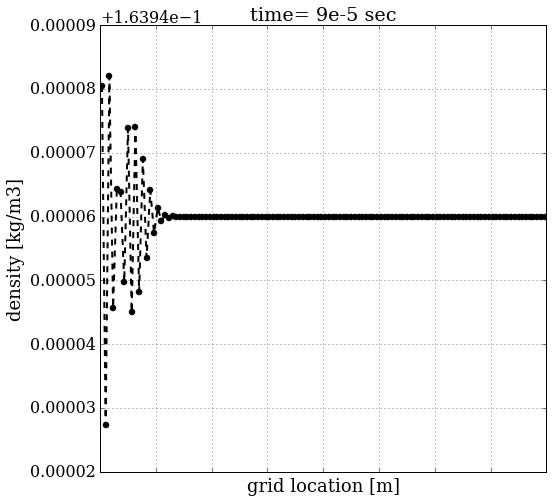

In [130]:
plot( xc,rhos[0][1:-1], 'grid location [m]','density [kg/m3]',  'time= 9e-5 sec')

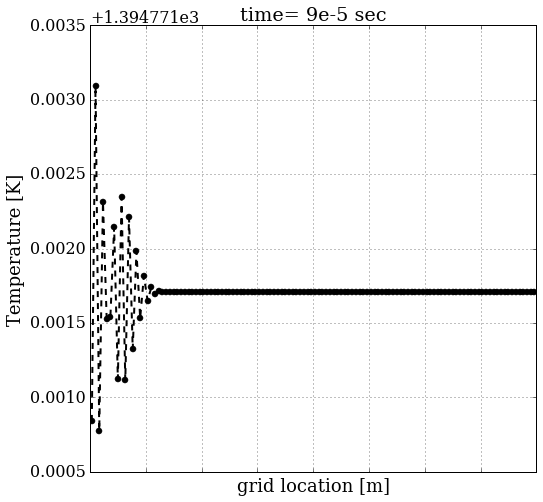

In [131]:
plot( xc,Ts[0][1:-1], 'grid location [m]','Temperature [K]',  'time= 9e-5 sec')

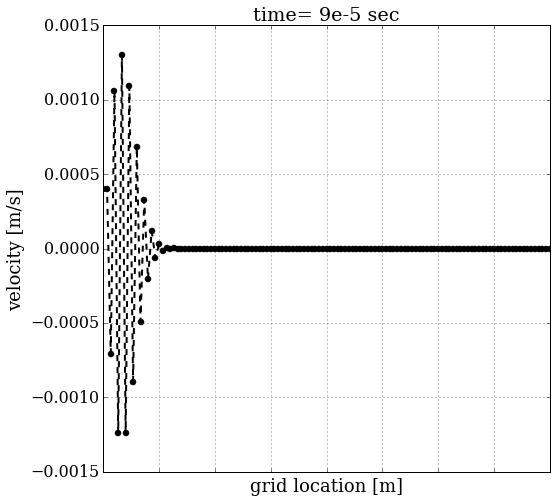

In [132]:
plot( xb,us[0][1:-1], 'grid location [m]','velocity [m/s]',  'time= 9e-5 sec')

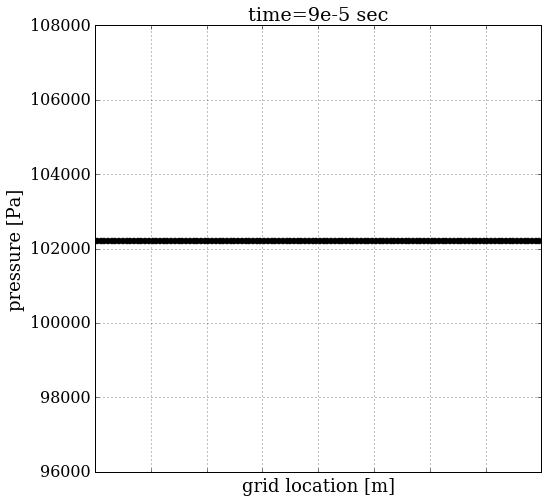

In [133]:
plot( xc,ps[0][1:-1], 'grid location [m]','pressure [Pa]',  'time=9e-5 sec')

##### intermediate time

In [134]:
test = numpy.zeros_like(Ts)
array_size = numpy.size(test[:,0])
mid_time = int(array_size/2)

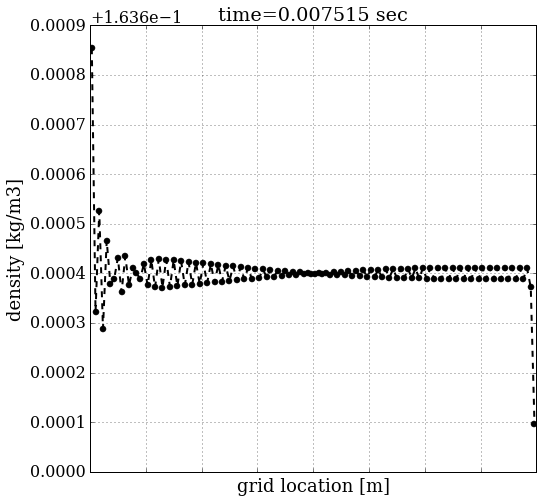

In [135]:
plot( xc,rhos[mid_time][1:-1], 'grid location [m]','density [kg/m3]',  'time=0.007515 sec')

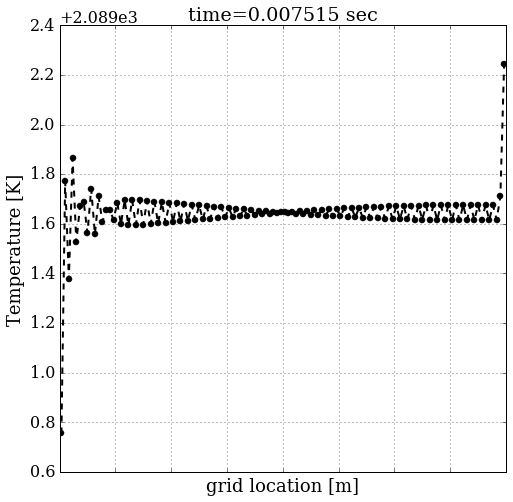

In [136]:
plot( xc,Ts[mid_time][1:-1], 'grid location [m]','Temperature [K]',  'time=0.007515 sec')

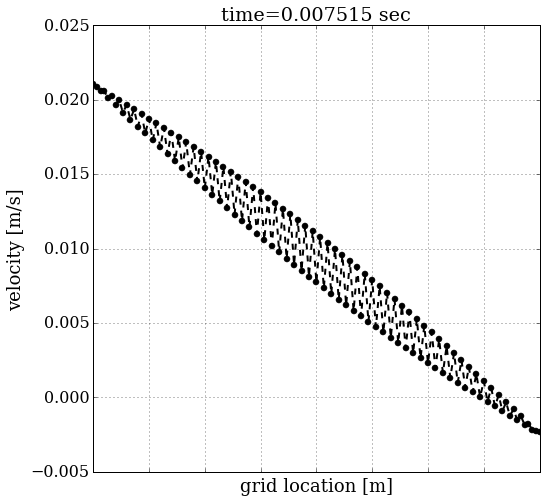

In [137]:
plot( xb,us[mid_time][1:-1], 'grid location [m]','velocity [m/s]',  'time=0.007515 sec')

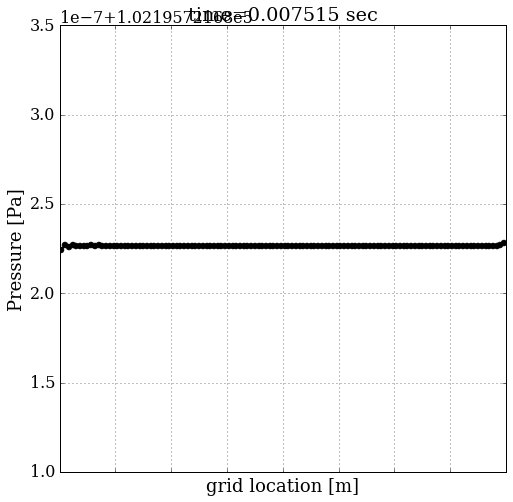

In [138]:
plot( xc,ps[mid_time][1:-1], 'grid location [m]','Pressure [Pa]',  'time=0.007515 sec')

##### final time

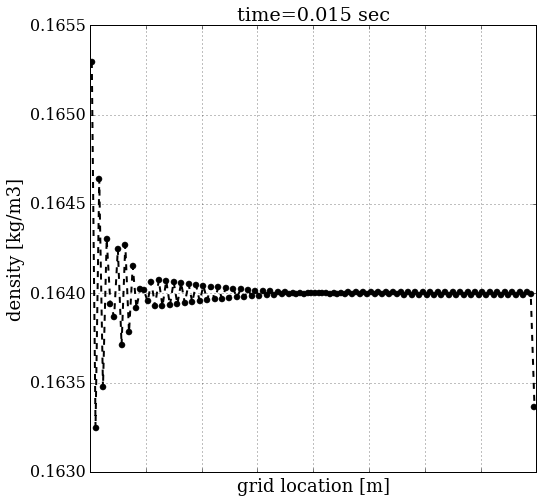

In [139]:
plot( xc,rhos[-1][1:-1], 'grid location [m]','density [kg/m3]',  'time=0.015 sec')

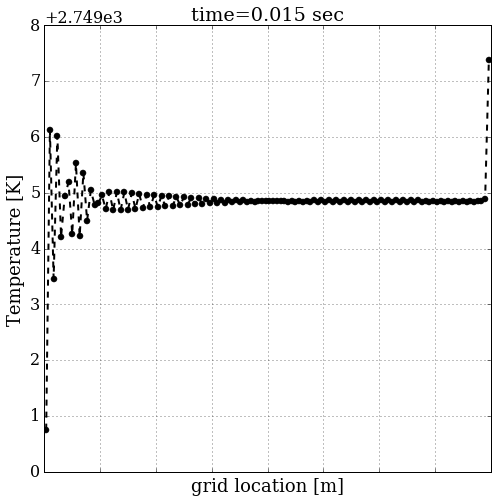

In [140]:
plot( xc,Ts[-1][1:-1], 'grid location [m]','Temperature [K]',  'time=0.015 sec')

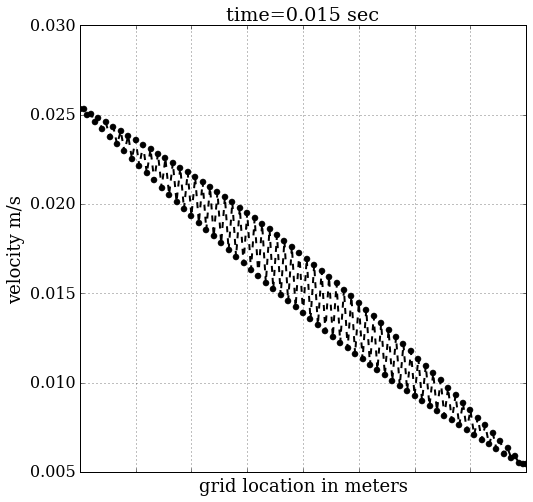

In [141]:
plot( xb,us[-1][1:-1], 'grid location in meters','velocity m/s',  'time=0.015 sec')

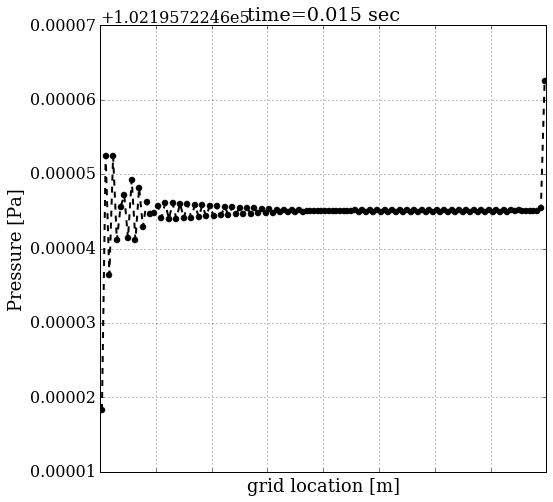

In [142]:
plot( xc,ps[-1][1:-1], 'grid location [m]','Pressure [Pa]',  'time=0.015 sec')